# German_Traffic_Sign_Recognition
## About Dataset
### Context
The [German Traffic Sign Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?datasetId=82373)
 is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

* Single-image, multi-class classification problem
* More than 40 classes
* More than 50,000 images in total
* Large, lifelike database

**Acknowledgements** \
INI Benchmark Website


## Imports

In [35]:
import logging
import os

# ignore all the warning and debug information from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from sklearn.metrics import classification_report
from libs.nn.conv.lenet import LeNet
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from pathlib import Path
import os

In [4]:

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

2023-02-17 13:24:00.801543: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


[]

## Prepare Dataset for training

In [5]:
# Look into the data directory
images_dir = './gtsrb-german-traffic-sign'

dataset_dir = f'{images_dir}/Train'

In [6]:
BATCH_SIZE = 32
IMG_WIDTH = IMG_HEIGHT = 32
RANDOM_STATE=42

In [7]:
classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

In [8]:
len(classes.keys())

43

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  shuffle=True,
  label_mode='categorical' ,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [10]:
val_ds = keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical' ,
  shuffle=True,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  seed=42,
  batch_size=BATCH_SIZE,)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [11]:
for x, y in train_ds.take(1):
    print(x)
    print(y)
    break

tf.Tensor(
[[[[ 12.        11.        13.      ]
   [ 12.        11.        14.      ]
   [ 12.        10.        13.      ]
   ...
   [ 12.        11.        14.      ]
   [ 12.        10.        13.      ]
   [ 11.        10.        13.      ]]

  [[ 12.        11.        13.      ]
   [ 11.        10.        13.      ]
   [ 12.        10.        12.      ]
   ...
   [ 11.        10.        13.      ]
   [ 13.        11.        13.      ]
   [ 11.        10.        12.      ]]

  [[ 13.        11.        13.      ]
   [ 13.        11.        13.      ]
   [ 12.        10.        12.      ]
   ...
   [ 10.         9.        11.      ]
   [ 12.        10.        12.      ]
   [ 12.        10.        12.      ]]

  ...

  [[ 13.        11.        13.      ]
   [ 12.        10.        13.      ]
   [ 13.        11.        14.      ]
   ...
   [ 14.        12.        14.      ]
   [ 13.        12.        15.      ]
   [ 13.        11.        15.      ]]

  [[ 12.        10.        12.    

labels are already one-hot encoded, now we have to normalize the images, that will be done in side the model (1st Sequential layer)

## Prepare CNN Model

Setting up the callbacks

In [12]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint("model/ge_traffic_sign",
                                                         save_best_only=True)

run_index = 1 # increment every time you train the model
run_logdir = Path() / "ge_traffic_sign_recog" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [13]:
model = LeNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth= 3, classes=len(classes.keys()))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 20)        1520      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 50)        25050     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 50)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0

In [14]:
EPOCHS = 100
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=0.01/EPOCHS, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Configure the dataset for performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train the Model

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [17]:
history = model.fit(train_ds,
                        validation_data=val_ds,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks)

Epoch 1/100
979/981 [============================>.] - ETA: 0s - loss: 0.9591 - accuracy: 0.7360

981/981 [==============================] - 14s 13ms/step - loss: 0.9573 - accuracy: 0.7364 - val_loss: 0.2101 - val_accuracy: 0.9453
Epoch 2/100
978/981 [============================>.] - ETA: 0s - loss: 0.1045 - accuracy: 0.9706

981/981 [==============================] - 13s 13ms/step - loss: 0.1043 - accuracy: 0.9707 - val_loss: 0.0874 - val_accuracy: 0.9767
Epoch 3/100
979/981 [============================>.] - ETA: 0s - loss: 0.0432 - accuracy: 0.9887

981/981 [==============================] - 13s 13ms/step - loss: 0.0431 - accuracy: 0.9887 - val_loss: 0.0565 - val_accuracy: 0.9862
Epoch 4/100
978/981 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9941

981/981 [==============================] - 13s 13ms/step - loss: 0.0237 - accuracy: 0.9941 - val_loss: 0.0508 - val_accuracy: 0.9862
Epoch 5/100
979/981 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9976

981/981 [==============================] - 13s 13ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.0448 - val_accuracy: 0.9893
Epoch 6/100
981/981 [==============================] - 12s 13ms/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 0.0466 - val_accuracy: 0.9897
Epoch 7/100
978/981 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9988

981/981 [==============================] - 13s 13ms/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 0.0340 - val_accuracy: 0.9918
Epoch 8/100
981/981 [==============================] - 12s 13ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0381 - val_accuracy: 0.9915
Epoch 9/100
981/981 [==============================] - 12s 12ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0486 - val_accuracy: 0.9879
Epoch 10/100
981/981 [==============================] - 12s 13ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0406 - val_accuracy: 0.9913
Epoch 11/100
981/981 [==============================] - 12s 12ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.0349 - val_accuracy: 0.9912
Epoch 12/100
981/981 [==============================] - 12s 13ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0357 - val_accuracy: 0.9931
Epoch 13/100
981/981 [==============================] - 12s 13ms/step - loss: 5.8568e-04 - accuracy: 0.9999 - val_loss: 0.0371 - val_accura

## Evaluate the Model

In [50]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

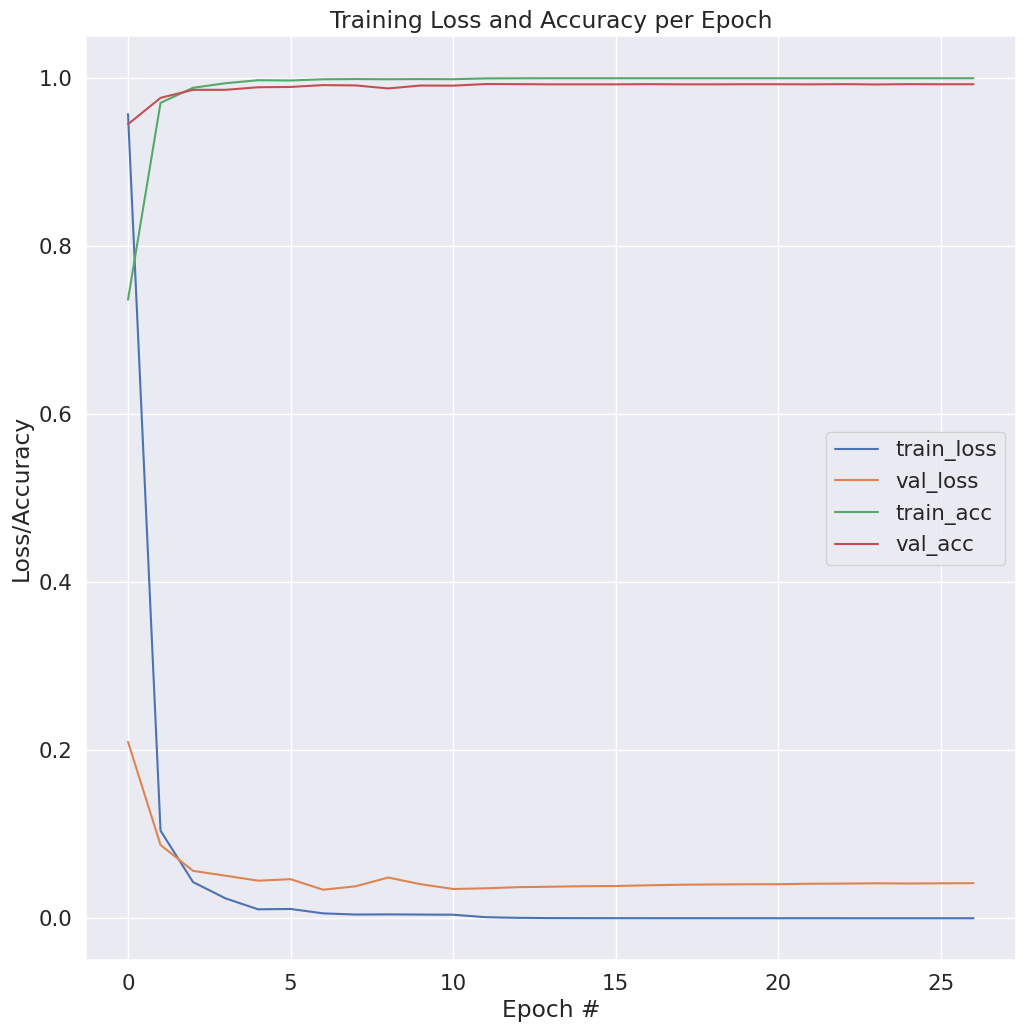

In [52]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy per Epoch")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [19]:
loss, accuracy = model.evaluate(val_ds)
loss, accuracy

246/246 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9918


(0.03404991701245308, 0.9918377995491028)

In [44]:
predicted = model.predict(val_ds)
for pred in predicted[:3]:
    print(pred)

246/246 [==============================] - 1s 2ms/step
[1.4489695e-12 3.7667612e-11 7.5941632e-18 4.5475181e-18 1.6238004e-19
 1.4816438e-18 5.3142207e-16 2.3486223e-13 1.1677040e-13 3.2339172e-15
 4.4700914e-16 1.8809415e-19 4.2194807e-15 3.9425572e-15 2.3595455e-18
 3.6156654e-19 5.4207656e-18 5.1357079e-13 1.8430396e-21 2.2535534e-13
 4.2865307e-16 1.4457133e-14 3.6987057e-15 1.9481087e-21 1.8919185e-16
 2.4108277e-15 1.1105352e-16 2.0704048e-16 3.7527067e-18 1.2238691e-17
 1.5810380e-19 6.7383656e-15 5.0092181e-19 7.4163809e-17 4.6142608e-07
 9.9391610e-13 1.3251411e-18 8.3127674e-17 3.0955700e-11 6.0845180e-15
 3.6577655e-06 9.9999577e-01 1.6460426e-16]
[3.54908707e-11 7.54922596e-08 2.92518118e-04 1.42217411e-08
 1.05540614e-07 3.57835916e-09 4.74440498e-07 5.89139537e-09
 2.18542959e-06 1.28778987e-10 4.45993003e-08 7.22740534e-10
 2.27852997e-05 3.12217807e-09 2.95810987e-10 3.30160378e-13
 1.65348935e-09 2.55305537e-08 6.64671829e-09 3.55144856e-08
 3.38615891e-09 4.94482955e-

In [45]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  actual =np.argmax(actual, axis=1) # because one hot encoded 
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [47]:
actual, predicted = get_actual_predicted_labels(val_ds)
actual[:10], predicted[:10].numpy()

246/246 [==============================] - 0s 2ms/step


(array([41, 40,  4,  3,  3, 24, 41,  5,  1, 18]),
 array([41, 40,  4,  3,  3, 24, 41,  5,  1, 18]))

In [34]:
print(classification_report(actual, predicted,
                            target_names=classes.values()))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        44
           1       0.99      0.99      0.99       448
           2       0.99      1.00      1.00       390
           3       0.99      0.99      0.99       297
           4       0.99      1.00      0.99       396
           5       1.00      0.99      0.99       441
           6       1.00      0.99      1.00       173
           7       0.99      0.99      0.99       146
           8       1.00      1.00      1.00        82
           9       1.00      1.00      1.00       206
          10       1.00      1.00      1.00       248
          11       1.00      0.98      0.99        46
          12       1.00      0.99      1.00       429
          13       0.93      1.00      0.96        67
          14       0.95      0.99      0.97        75
          15       0.99      1.00      0.99        89
          16       1.00      0.97      0.98        98
          17       1.00    

## Save the Best performing model

In [48]:
saved_model_path = 'model/ge_traffic_sign_recognition.h5'
model.save(saved_model_path)